In [2]:
import json 
import jsonpath  
import pandas as pd
import pyomo
from coptpy import * 
from pyomo.core import *
from pyomo.environ import *
from pyomo.gdp import *
import pyomo.opt as pyopt
from copt_pyomo import *
from pyomo.environ import SolverFactory

Cardinal Optimizer v7.1.4. Build date Jun 27 2024
Copyright Cardinal Operations 2024. All Rights Reserved



data prepare

In [3]:
s = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007472, 0.468496, 0.973569, 1.080769, 2.233786, 3.014249, 1.58843, 1.236549, 1.226271, 0.778061, 0.743909, 0.516943, 0.217693, 0.000538, 0.0, 0.0, 0.0, 0.0]
s_new = [i / 15 for i in s]
print(s_new)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004981333333333334, 0.031233066666666667, 0.0649046, 0.07205126666666667, 0.14891906666666666, 0.20094993333333333, 0.10589533333333333, 0.0824366, 0.0817514, 0.051870733333333335, 0.04959393333333333, 0.03446286666666667, 0.014512866666666667, 3.5866666666666667e-05, 0.0, 0.0, 0.0, 0.0]


In [82]:
class PG():
    def __init__(self):
        self.electric_price = [0.23656, 0.23656, 0.23656, 0.23656, 0.23656, 0.23656, 0.23656, 0.75, 0.75, 0.75, 1.23, 1.23, 1.23, 0.75, 0.75, 0.75, 1.16, 1.16, 1.16, 1.16, 1.16, 0.75, 0.75, 0.23656]
        self.maximum_purchase_quantity = 0
        self.minimum_purchase_quantity = 0
class PV():
    def __init__(self):
        self.brand = ''
        self.product_code = ''
        # self.fixed_cost = 0
        # self.variable_cost = 0
        self.energy_density = 0.228
        self.component_cost = 1.37
        self.efficiency = 0.228
        self.inverter_cost = 185.5
        self.other_cost = 1000
        self.maintenance_cost = 0.035
        self.service_life = 25
        self.maximum_installation_area = 100000
        self.minimum_installation_area = 0
        self.installation_orientation = 0
        self.fixed_installation_angle = 0
        self.time_based_irradiance = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004981333333333334, 0.031233066666666667, 0.0649046, 0.07205126666666667, 0.14891906666666666, 0.20094993333333333, 0.10589533333333333, 0.0824366, 0.0817514, 0.051870733333333335, 0.04959393333333333, 0.03446286666666667, 0.014512866666666667, 3.5866666666666667e-05, 0.0, 0.0, 0.0, 0.0]
        
        ## 模型输入量
        self.cost_coefficient = self.get_pv_cost_coefficient()
        self.pv_amount = self.get_pv_amount()
        
    def get_pv_amount(self):
        pv_amount = []
        for i in range(len(self.time_based_irradiance)):
            pv_amount.append(self.time_based_irradiance[i] * self.efficiency)
        return pv_amount
    
    def get_pv_cost_coefficient(self):
        cost = self.energy_density * (self.component_cost + self.inverter_cost + self.other_cost + self.maintenance_cost) / self.service_life / 365
        return cost
        
class BES():
    def __init__(self):
        self.brand = ''
        self.product_code = ''
        self.fixed_cost = 111
        self.variable_cost = 1500
        self.maintenance_cost = 0.012
        self.service_life = 8
        self.charge_efficiency = 0.9
        self.discharge_efficiency = 0.9
        self.self_discharge_rate = 1
        self.dod = 0.2
        self.charge_rate = 0.5             # 这块的充放电效率应该指的是最大充电倍率
        self.discharge_rate = 0.5
        self.cycle_count = 6000
        self.cell_capacity = 0.895
        self.maximum_installation_capacity = 10000
        self.minimum_installation_capacity = 0
        
        # 模型输入量
        self.bes_cost_coefficient = self.get_battery_cost_coefficient()
        
    def get_battery_cost_coefficient(self):
        cost_coefficient = (self.variable_cost + self.maintenance_cost) / self.service_life / 365
        return cost_coefficient
    
    
    
class Load():
    def __init__(self):
        self.time_based_load = [589.445345, 292.356323, 227.97296, 374.306145, 357.786628, 373.37191, 938.965463, 600.83158, 154.400695, 38.962353, 39.834795, 83.481465, 210.051895, 135.87068, 0.0, 23.08895, 41.090158, 189.25883, 75.636853, 123.268245, 168.739288, 221.243632, 262.912402, 233.915705]
class MR():                               # Meteorological Resources
    def __init__(self):
        self.time_based_irradiance = []
# pg = PG()
# pv = PV()
# bes = BES()
# load = Load()
# print(pg.electric_price,pv.pv_amount,pv.cost_coefficient,bes.bes_cost_coefficient,load.time_based_load)

pyomo

In [83]:
pg = PG()
pv = PV()
bes = BES()
load = Load()
# load.time_based_load = [i * 3 for i in load.time_based_load]
# pv.cost_coefficient = [i * 2 for i in pv.cost_coefficient]

n = 24

# 0. 模型
model = ConcreteModel()

# 1. 索引集合
model.i = RangeSet(0, n - 1)#优化序列长度  
model.j = RangeSet(0, n)#优化序列长度  

# 2. 参数集合
model.param_big_M = Param(initialize = 100000)

model.param_pv_cost_coefficient = Param(initialize = pv.cost_coefficient)
model.param_pv_amount = Param(model.i, initialize = pv.pv_amount)

model.param_battery_cost_coefficient = Param(initialize = bes.bes_cost_coefficient)
model.param_battery_fixed_cost = Param(initialize = bes.fixed_cost)

model.param_electricity_price = Param(model.i, initialize = pg.electric_price)

# 3. 变量
model.var_x1 = Var(within = NonNegativeReals, bounds = (0, pv.maximum_installation_area), initialize = 0)

model.var_x2 = Var(within = NonNegativeReals, bounds = (0, bes.maximum_installation_capacity), initialize = 0)

model.var_y = Var(model.i, within = NonNegativeReals, initialize = 0)

model.var_z = Var(model.i, within = Reals, initialize = 0)      # 电池的充放电量

model.var_electric_amount = Var(model.j, within = NonNegativeReals, initialize = 0)

model.var_z_for_real = Var(model.i, within = Reals, initialize = 0)     # 电池充放电量对应的实际需求电量或者放电量（考虑效率之后） todo  大M法
model.var_z_binary  = Var(model.i, within = Binary, initialize = 0) 
model.var_charge_amount = Var(model.i, within=NonNegativeReals, initialize = 0)
model.var_discharge_amount = Var(model.i, within=NonNegativeReals, initialize = 0)

# 4. 表达式
# 4.1 投资成本
model.expr_invest_cost = Expression(expr = model.param_pv_cost_coefficient * model.var_x1 + model.param_battery_cost_coefficient * model.var_x2 + model.param_battery_fixed_cost)

# 4.2 运行成本
model.expr_operation_cost = Expression(expr = sum(model.var_y[i] * model.param_electricity_price[i] for i in model.i))

# 5. 目标
model.obj = Objective(expr = model.expr_operation_cost + model.expr_invest_cost, sense = minimize)

# 6. 约束
model.constraints = ConstraintList()

# 6.1 满足负荷
for i in model.i:
    model.constraints.add(model.var_y[i] + model.var_x1 * model.param_pv_amount[i] * pv.efficiency + model.var_z_for_real[i] >= load.time_based_load[i])
    
# 6.2 电池充放电需要满足的约束
model.constraints.add(model.var_z[0] <= 0)
model.constraints.add(-model.var_z[0] <= model.var_x2)
model.constraints.add(model.var_electric_amount[0] == 0)
model.constraints.add(model.var_z[0] <= model.var_x2 * bes.charge_rate )   ## 充放电功率限制
model.constraints.add(-model.var_z[0] <= model.var_x2 * bes.discharge_rate)
for i in range(1, n):
    model.constraints.add(model.var_z[i] <= model.var_electric_amount[i])
    model.constraints.add(-model.var_z[i] <= model.var_x2 - model.var_electric_amount[i])
    
    model.constraints.add(model.var_electric_amount[i] == model.var_electric_amount[i - 1] - model.var_z[i - 1])
    
    model.constraints.add(model.var_z[i] <= model.var_x2 * bes.charge_rate)   ## 充放电功率限制
    model.constraints.add(-model.var_z[i] <= model.var_x2 * bes.discharge_rate)

# 6.6 充放电
for i in model.i:
    model.constraints.add(model.var_charge_amount[i] <= model.param_big_M * (1 - model.var_z_binary[i]))
    model.constraints.add(model.var_discharge_amount[i] <= model.param_big_M * model.var_z_binary[i])
    model.constraints.add(model.var_discharge_amount[i] - model.var_charge_amount[i] == model.var_z[i])   
    model.constraints.add(model.var_z_for_real[i] == model.var_discharge_amount[i] * 0.9 - model.var_charge_amount[i] * 1.1)   
    
solver = pyopt.SolverFactory('copt_direct')
solver.options['IntTol'] = 0


results = solver.solve(model, tee = True)
# Check result
if results.solver.status == pyopt.SolverStatus.ok and results.solver.termination_condition == pyopt.TerminationCondition.optimal:
     print("Optimal solution found")
else:
     print("Something unexpected happened: ", str(results.solver))
print("---------------------------pv装机面积----------------------------------")
print(value(model.var_x1),"m^2")
print("---------------------------pv的发电量---------------------------------")
pv_amount_real = []
for i in model.i:
    pv_amount_real.append(model.param_pv_amount[i] * value(model.var_x1))
print(pv_amount_real)

print("---------------------------bes装机量----------------------------------")
print(value(model.var_x2),"kWh")
bes_act = []
bes_act_amount = []
bes_amount = []
for i in model.i:
    bes_act.append(value(model.var_z[i]) / (value(model.var_x2)))
    bes_act_amount.append(value(model.var_z[i]))
    bes_amount.append(value(model.var_electric_amount[i]))
print("---------------------------充放动作----------------------------------")
print(bes_act)
print("---------------------------充放电量----------------------------------")
print(bes_act_amount)
print("---------------------------电池电量----------------------------------")
print(bes_amount)

print("---------------------------买电量----------------------------------")
buy_amount = []
for i in model.i:
    buy_amount.append(value(model.var_y[i]))
print(buy_amount, "kWh")

print("---------------------------单日成本----------------------------------")
print(value(model.obj))
print("---------------------------单日投资成本----------------------------------")
print(value(model.expr_invest_cost))
print("---------------------------单日运营成本----------------------------------")
print(value(model.expr_operation_cost))
print("--------------------------未投入绿电时的单日成本--------------------------")
cost_tmp = 0
for i in model.i:
    cost_tmp += load.time_based_load[i] * pg.electric_price[i]
print(cost_tmp)
print("--------------------------投入绿电之后单日节省的成本-----------------------")
print(cost_tmp - value(model.obj))

print("--------------------------绿电投资的总成本----------------------------")
print(value(model.expr_invest_cost) * 365)

print("--------------------------按照典型日状况计算的回本周期-----------------------")
print(value(model.expr_invest_cost) * 365/(cost_tmp - value(model.obj)),"天")

Setting parameter 'IntTol' to 1e-09 (MIN)
Model fingerprint: 4897e428

Using Cardinal Optimizer v7.1.4 on Windows
Hardware has 6 cores and 12 threads. Using instruction set X86_AVX2 (10)
Minimizing a MIP problem

The original problem has:
    240 rows, 171 columns and 586 non-zero elements
    24 binaries

Starting the MIP solver with 12 threads and 32 tasks

Presolving the problem

The presolved problem has:
    185 rows, 140 columns and 475 non-zero elements
    23 binaries


     Nodes    Active  LPit/n  IntInf     BestBound  BestSolution    Gap   Time
         0         1      --       0  2.504392e+02            --    Inf  0.02s
H        0         1      --       0  2.504392e+02  2.808748e+03  91.1%  0.03s
         0         1      --       8  2.648899e+03  2.808748e+03  5.69%  0.05s
H        0         1      --       8  2.648899e+03  2.648899e+03  0.00%  0.05s
         1         0     0.0       8  2.648899e+03  2.648899e+03  0.00%  0.05s
         1         0     0.0       8  2.648

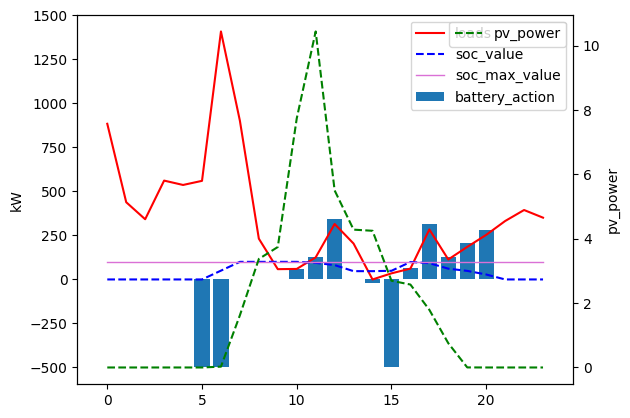

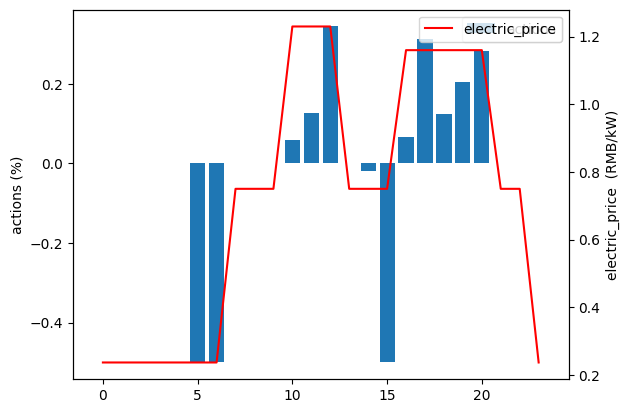

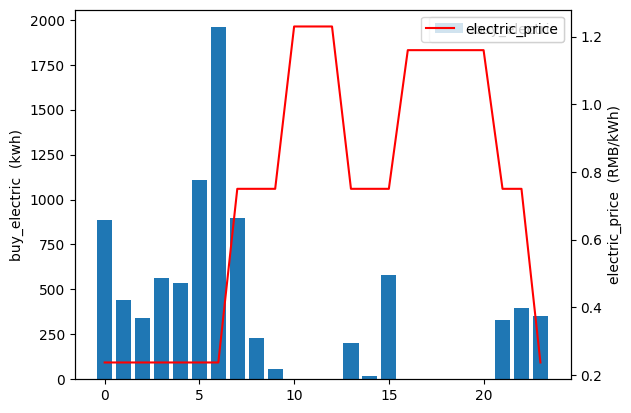

In [17]:
from matplotlib import pyplot as plt
# actions = actions_test1
# states = states1
# buy_electric = buy_electric1
actions = bes_act
states = [i / value(model.var_x2) for i in bes_amount]
buy_electric = buy_amount

# add
soc_value = [states[i] * 100 for i in range(len(states))]
soc_max_value = [100 for i in range(len(states))]


soc_state = [i * value(model.var_x2) for i in states]
battery_action = [i * value(model.var_x2) for i in actions]
electric_price = pg.electric_price
#load = [load.time_based_load[i]  for i in range(n)]
x = range(n)
fig, ax1 = plt.subplots() 

ax1.plot(range(n),load.time_based_load ,'r',label = 'loads')
ax1.plot(range(n),soc_value,'b--',label = 'soc_value')
ax1.plot(range(n),soc_max_value, color='orchid', linewidth=1 ,label = 'soc_max_value')
ax1.bar(range(n), [i * value(model.var_x2) for i in actions], label = 'battery_action')
ax1.set_ylabel('kW')

pv_power_tmp = [value(model.var_x1)* model.param_pv_amount[i] * pv.efficiency for i in range(len(actions))]

ax2 = ax1.twinx()  # 创建第二个y轴  
ax2.plot(range(n),pv_power_tmp,'g--',label = 'pv_power')
ax2.set_ylabel('pv_power')  # 设置第二个y轴的标签  
ax1.legend()
ax2.legend()
plt.savefig('my_plot1.png', facecolor='white')
plt.show()
# 创建两个子图，共享x轴，但有各自的y轴  
fig, ax1 = plt.subplots()  
ax1.bar(x, actions, label = 'actions')  # 使用蓝色线条绘制第一个曲线  
ax1.set_ylabel('actions (%)')  # 设置第一个y轴的标签  
ax2 = ax1.twinx()  # 创建第二个y轴  
ax2.plot(x, electric_price, 'r-',label = 'electric_price')  # 使用红色线条绘制第二个曲线  
ax2.set_ylabel('electric_price  (RMB/kW)')  # 设置第二个y轴的标签  
ax1.legend()
ax2.legend()
plt.savefig('my_plot2.png', facecolor='white')
plt.show()

# 创建两个子图，共享x轴，但有各自的y轴  
fig, ax1 = plt.subplots()  
ax1.bar(x, buy_electric, label = 'buy_electric')  # 使用蓝色线条绘制第一个曲线  
ax1.set_ylabel('buy_electric  (kwh)')  # 设置第一个y轴的标签  
  
ax2 = ax1.twinx()  # 创建第二个y轴  
ax2.plot(x, electric_price, 'r-',label = 'electric_price')  # 使用红色线条绘制第二个曲线  
ax2.set_ylabel('electric_price  (RMB/kWh)')  # 设置第二个y轴的标签  
ax1.legend()
ax2.legend()
plt.savefig('my_plot3.png', facecolor='white')
plt.show()